In [163]:
import torch
import numpy as np
import matplotlib.pyplot as plt

num_points = 100

def get_random_points(amount=100):
    points = np.random.uniform(-1.0, 1.0, size=(amount, 2)).astype(np.float32)

    return points.flatten()

points_groups = [get_random_points(num_points) for _ in range(5)]
points_groups_tensor = torch.tensor(np.stack(points_groups, axis=0))

num_lines = points_groups_tensor.shape[0]
points = points_groups_tensor.view(num_lines, num_points, 2)

In [164]:
def get_segments_length(points):
    diffs = points[:, 1:, :] - points[:, :-1, :]
    return torch.linalg.vector_norm(diffs, dim=2)

def loss_distance(points):
    seg_lengths = get_segments_length(points)
    mean_len = seg_lengths.mean(dim=1, keepdim=True)
    return ((seg_lengths - mean_len)**2).mean()

def loss_length(points):
    seg_lengths = get_segments_length(points)
    line_lengths = seg_lengths.sum(dim=1)
    mean_length = line_lengths.mean()
    return ((line_lengths - mean_length)**2).mean()

def loss_sin(points, target_x, target_y):
    x = points[..., 0]
    y = points[..., 1]
    return ((x - target_x)**2 + (y - target_y)**2).mean()

In [165]:
def get_sin_target_values():
    target_x_spaced = torch.linspace(0, 1, num_points).unsqueeze(0)
    target_x_spaced = target_x_spaced.expand(num_lines, -1)

    target_x = target_x_spaced.clone()

    amplitude = torch.rand(num_lines, 1) * 0.5 + 0.5
    phase = torch.rand(num_lines, 1) * 2 * np.pi
    shift = torch.rand(num_lines, 1) * 1.0 - 0.5

    target_y = amplitude * torch.sin(2 * np.pi * target_x + phase) + shift

    return (target_x, target_y)

In [166]:
trainable_points = points.clone().detach().requires_grad_(True)
optimizer = torch.optim.Adam([trainable_points], lr=0.0005)
(target_x, target_y) = get_sin_target_values()

In [167]:
phase_1_epochs_amount = 5000
phase_2_epochs_amount = 12000
phase_3_epochs_amount = 3000

for epoch in range(phase_1_epochs_amount + phase_2_epochs_amount):
    optimizer.zero_grad()

    if epoch < phase_1_epochs_amount:
        loss = (
            2.0 * loss_distance(trainable_points) +
            0.05 * loss_length(trainable_points)
        )
    elif epoch < phase_1_epochs_amount + phase_2_epochs_amount:
        loss = (
            1.0 * loss_distance(trainable_points) +
            0.1 * loss_length(trainable_points) +
            0.2 * loss_sin(trainable_points, target_x, target_y)
        )
    else:
        loss = (
            3.0 * loss_distance(trainable_points) +
            0.2 * loss_length(trainable_points) +
            0.05 * loss_sin(trainable_points, target_x, target_y)
        )

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, loss={loss.item():.6f}")

Epoch 0, loss=5.295818
Epoch 200, loss=0.500334
Epoch 400, loss=0.382110
Epoch 600, loss=0.322305
Epoch 800, loss=0.273325
Epoch 1000, loss=0.233659
Epoch 1200, loss=0.201064
Epoch 1400, loss=0.172696
Epoch 1600, loss=0.148656
Epoch 1800, loss=0.128230
Epoch 2000, loss=0.110523
Epoch 2200, loss=0.095024
Epoch 2400, loss=0.081345
Epoch 2600, loss=0.069199
Epoch 2800, loss=0.058414
Epoch 3000, loss=0.048896
Epoch 3200, loss=0.040578
Epoch 3400, loss=0.033380
Epoch 3600, loss=0.027208
Epoch 3800, loss=0.021967
Epoch 4000, loss=0.017568
Epoch 4200, loss=0.013924
Epoch 4400, loss=0.010945
Epoch 4600, loss=0.008541
Epoch 4800, loss=0.006620
Epoch 5000, loss=0.262851
Epoch 5200, loss=0.227781
Epoch 5400, loss=0.203105
Epoch 5600, loss=0.183014
Epoch 5800, loss=0.165688
Epoch 6000, loss=0.150303
Epoch 6200, loss=0.136405
Epoch 6400, loss=0.123718
Epoch 6600, loss=0.112049
Epoch 6800, loss=0.101266
Epoch 7000, loss=0.091267
Epoch 7200, loss=0.081983
Epoch 7400, loss=0.073360
Epoch 7600, loss=0.

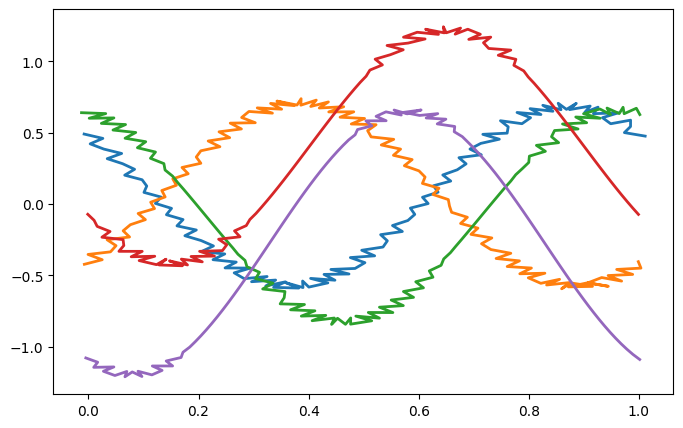

In [168]:
points_np = trainable_points.detach().cpu().numpy()

plt.figure(figsize=(8, 5))

for i in range(num_lines):
    plt.plot(points_np[i,:,0], points_np[i,:,1], linewidth=2)

plt.show()